# Pipeline for Training and Analysis of 20 2x100 FC models

## Imports and Hyperparameters

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Subset

from src.cifar.models import *
from src.util import split_train_val, test, train, save_model

import matplotlib.pyplot as plt

import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# this should print 'cuda' if you are assigned a GPU
print(device)

train_batch_size = 100
test_batch_size = 100
n_epochs = 5
learning_rate = 1e-2
seed = 100
input_dim = 32*32*3
out_dim = 10
num_hidden_layers = 2
layer_size = 100
momentum = 0.9

fc_model_params = [(2,100)]*20

complex_models = []

cuda


## Load Data

In [2]:
transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])
train_dataset = torchvision.datasets.CIFAR10('./datasets/', train=True, download=True, transform=transforms)
test_dataset = torchvision.datasets.CIFAR10('./datasets/', train=False, download=True, transform=transforms)

raw_test_data = torchvision.datasets.CIFAR10('./datasets/', train=False, download=True, transform=torchvision.transforms.ToTensor())

# sanity check
print('training data size:{}'.format(len(train_dataset)))
print('test data size:{}'.format(len(test_dataset)))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
training data size:50000
test data size:10000


In [3]:
train_dataset, val_dataset = split_train_val(train_dataset, valid_ratio=1/6)
print('training data size:{}'.format(len(train_dataset)))
print('validation data size:{}'.format(len(val_dataset)))

training data size:41667
validation data size:8333


## Loaders

In [4]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=train_batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)
raw_test_loader = torch.utils.data.DataLoader(raw_test_data, batch_size=test_batch_size, shuffle=False)

# sanity check
print('training data size:{}'.format(len(train_loader.dataset)))
print('validation data size:{}'.format(len(val_loader.dataset)))
print('test data size:{}'.format(len(test_loader.dataset)))

training data size:41667
validation data size:8333
test data size:10000


## Create Networks

In [5]:
fc_models = [FC(input_dim, out_dim, num_hidden_layers, layer_size) for num_hidden_layers, layer_size in fc_model_params]
complex_models = load_pretrained_models(complex_models)

## Train Networks

In [11]:
for i, model in enumerate(fc_models):
    model.to(device)

    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

    print("Training FC model {}".format(i+1))

    for epoch in range(1, n_epochs + 1):
        train(model, train_loader, optimizer, epoch, device)

    test(model, val_loader, device)

    print("Saving FC model: {}".format(model))
    save_model(model, dataset="CIFAR10", filename="FC" + str(i))

for i, model in enumerate(os.listdir("./models/CIFAR10/")):
    if model.endswith(".pth") and "FC" in model:
        fc_models[i].load_state_dict(torch.load("./models/CIFAR10/" + model))
        with torch.no_grad():
            test(fc_models[i].to(device), test_loader, device)

Training FC model 1

Train Epoch: 1 [0/41667 (0%)]	Loss: 0.756738

Train Epoch: 1 [10000/41667 (24%)]	Loss: 0.625260

Train Epoch: 1 [20000/41667 (48%)]	Loss: 0.763609

Train Epoch: 1 [30000/41667 (72%)]	Loss: 1.040231

Train Epoch: 1 [40000/41667 (96%)]	Loss: 0.804502
	Accuracy: 71.52%

Train Epoch: 2 [0/41667 (0%)]	Loss: 0.596043

Train Epoch: 2 [10000/41667 (24%)]	Loss: 0.735503

Train Epoch: 2 [20000/41667 (48%)]	Loss: 0.834104

Train Epoch: 2 [30000/41667 (72%)]	Loss: 1.073344

Train Epoch: 2 [40000/41667 (96%)]	Loss: 0.834384
	Accuracy: 72.26%

Train Epoch: 3 [0/41667 (0%)]	Loss: 0.835336

Train Epoch: 3 [10000/41667 (24%)]	Loss: 0.769956

Train Epoch: 3 [20000/41667 (48%)]	Loss: 0.706352

Train Epoch: 3 [30000/41667 (72%)]	Loss: 0.902869

Train Epoch: 3 [40000/41667 (96%)]	Loss: 0.783682
	Accuracy: 72.37%

Train Epoch: 4 [0/41667 (0%)]	Loss: 0.689258

Train Epoch: 4 [10000/41667 (24%)]	Loss: 0.564023

Train Epoch: 4 [20000/41667 (48%)]	Loss: 0.732185

Train Epoch: 4 [30000/41667

## Missclassification Tracking

Images tracked as tuples (batch_idx, image_idx) and can be accessed from dataset as test_dataset[batch_idx][image_idx]

In [12]:
misses = dict()
complex_list = list(complex_models.values())
for model in fc_models + complex_list:
    print("Starting model test: {}".format(model))

    model.to(device)
    model.eval()

    with torch.no_grad():
        
        for i, (data, target) in enumerate(test_loader):

            data = data.to(device)
            target = target.to(device)

            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)

            missed = pred.not_equal(target.data.view_as(pred)).view(-1).cpu().numpy()

            for j, miss in enumerate(missed):
                if miss:
                    if (i, j) in misses:
                        misses[(i, j)] += 1
                    else:
                        misses[(i, j)] = 1

    print("Finished")

Starting model test: FC(
  (layer_list): ModuleList(
    (0): Linear(in_features=3072, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=10, bias=True)
  )
)
Finished
Starting model test: FC(
  (layer_list): ModuleList(
    (0): Linear(in_features=3072, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=10, bias=True)
  )
)
Finished
Starting model test: FC(
  (layer_list): ModuleList(
    (0): Linear(in_features=3072, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=10, bias=True)
  )
)
Finished
Starting model test: FC(
  (layer_list): ModuleList(
    (0): Linear(in_features=3072, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=10, bias=True)

In [16]:
all_miss = {k: v for k, v in misses.items() if v > 0}
significant = {k: v for k, v in misses.items() if v > 19}
print(len(significant))
print(len(all_miss))

985
8855


In [19]:
y = all_miss.values()

fig = plt.figure(figsize=(12, 8), facecolor="w")
plt.hist(y, [x-0.5 for x in range(22)], edgecolor="k")
plt.xlabel("Number of Missclassifications")
plt.ylabel("Frequency")
plt.savefig("plots/CIFAR/im_freq.png")
plt.close()

KeyboardInterrupt: 

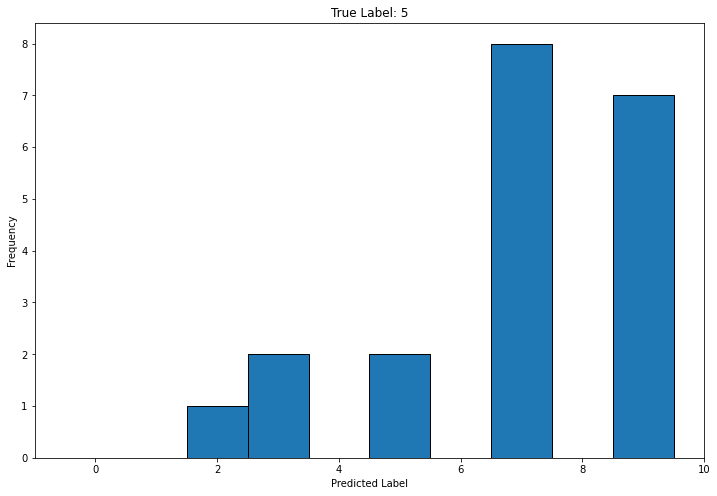

In [15]:
"""for sample in significant:

    idx = sample[0]*test_batch_size + sample[1]
    im_net = test_loader.dataset[idx][0].view(3, 32, 32)
    im_raw = raw_test_loader.dataset[idx][0].view(3, 32, 32)
    label = test_loader.dataset[idx][1]

    preds = np.array([model(im_net.unsqueeze(0).to(device)).argmax(dim=1, keepdim=True).cpu().numpy() for model in fc_models + complex_list]).flatten()
    fig = plt.figure(figsize=(12, 8), facecolor="w")
    plt.hist(preds, [x-0.5 for x in range(11)], edgecolor="k")
    plt.xlabel("Predicted Label")
    plt.ylabel("Frequency")
    plt.title("True Label: {}".format(label))
    plt.savefig("plots/CIFAR/images/im_" + str(idx) + "_freq.png")
    plt.close()

    fig = plt.figure()
    plt.imshow(im_raw.squeeze().cpu().numpy().transpose((1,2,0)))
    plt.title("Actual: {}".format(test_loader.dataset.targets[idx]))
    plt.savefig("plots/CIFAR/images/im_" + str(idx) + ".png")
    plt.close()"""